# Análise Exploratória de Dados

Primeiramente será feita uma análise inicial das imagens de tumor, com foco na variabilidade e na análise do PCA

In [1]:
from sklearn import datasets, svm, metrics
from sklearn.decomposition import PCA
import numpy as np
from math import ceil, floor

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
import cv2

import os

/home/mayra/miniconda3/lib/python3.7/site-packages/scipy/__init__.py:140: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.16.4)
  UserWarning)


### Organização dos dados

In [3]:
path = '../data/external/brain_tumor_dataset'

In [7]:

with os.scandir(path) as entries:
    for entry in entries:
        print(f"{path}/{entry.name}")
        folder = f"{path}/{entry.name}"
        abs_path = os.path.abspath(folder)
        with os.scandir(folder) as images:
            for i, image in enumerate(images):
                os.rename(f"{abs_path}/{image.name}", f"{abs_path}/{entry.name[0]}{i}.jpg")
                
                

../data/external/brain_tumor_dataset/no
../data/external/brain_tumor_dataset/yes


In [4]:
brain_tumor_n = []
brain_tumor_y = []

folder = f"{path}/no"
abs_path = os.path.abspath(folder)
with os.scandir(folder) as images:
    for i, image in enumerate(images):
        brain_tumor_n.append(cv2.imread(f"{abs_path}/{image.name}", 0))
        
folder = f"{path}/yes"
abs_path = os.path.abspath(folder)
with os.scandir(folder) as images:
    for i, image in enumerate(images):
        brain_tumor_y.append(cv2.imread(f"{abs_path}/{image.name}", 0))
        
print(len(brain_tumor_n))
print(len(brain_tumor_y))

98
155


### Análise das imagens

Começamos analisando as dimensões da imagens e realizando o redimensionamento caso necessário

## Crop nas imagens
Como a centralização dos cérebros não está padronizada, o diferentes formatos podem atrapalhar no processamento. Então vamos tentar amenizar isso realizando um corte na imagem

[11, 0, 227, 222, 615]


/home/mayra/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.


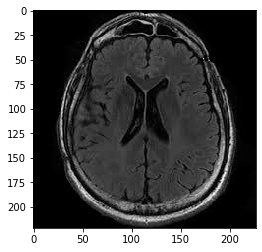

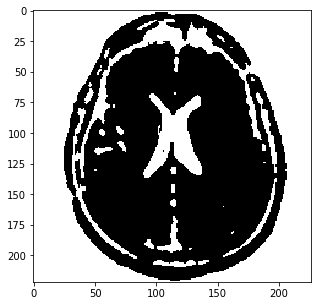

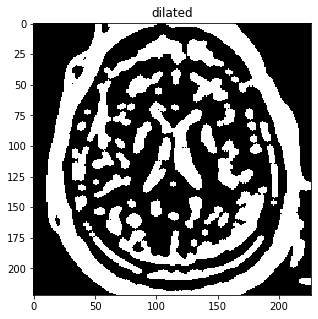

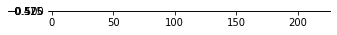

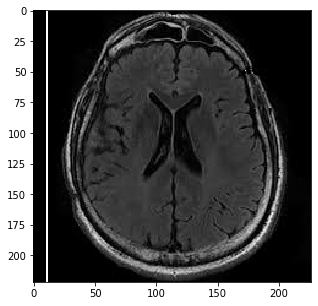

In [138]:
IMAGE = 11
plt.imshow(brain_tumor_n[IMAGE], cmap='gray')
blur = cv2.medianBlur(brain_tumor_n[IMAGE],5)
ret,thresh = cv2.threshold(blur, floor(np.average(blur)),255,cv2.THRESH_BINARY_INV)
th3 = cv2.adaptiveThreshold(blur, 255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,23, 1)
fig = plt.figure(figsize=(5, 5))
plt.imshow(thresh, cmap='gray')

# erosion followed by dilation
dilated=cv2.morphologyEx(th3,cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5, 5)))
fig = plt.figure(figsize=(5, 5))
plt.title("dilated")
plt.imshow(dilated, cmap='gray')
# kernel = np.ones((10,10),np.uint8)
# a = cv2.erode(thresh,kernel,iterations = 3)
# fig = plt.figure(figsize=(5, 5))
# plt.imshow(a, cmap='gray')
contours,_ = cv2.findContours(dilated,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

thickness = 2

# x y x1 y1 tamanho
best_box=[-1,-1,-1,-1, 0]
for c in contours:
    x,y,w,h = cv2.boundingRect(c)
    # print(f"x {x} y {y} w {w} h {h} ")
    
    # recupera contorno com mais elementos (mais elipsal)
    if best_box[0] < 0 or best_box[-1] < c.shape[0] :
        best_box=[x,y,x+w,y+h, c.shape[0]]
        

fig = plt.figure(figsize=(5, 5))
plt.imshow(img[rows, :], cmap='gray')
    
print(best_box)
#best_box = [63,16, 63 +31, 16+14]
pt1 = (best_box[0], best_box[1])
pt2 = (best_box[2], best_box[3])
img = brain_tumor_n[IMAGE].copy()
rect = cv2.rectangle(img, pt1, pt2, (255, 0, 0))
fig = plt.figure(figsize=(5, 5))
plt.imshow(rect, cmap='gray')

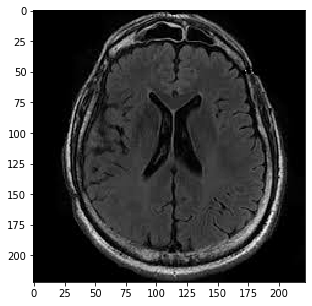

In [163]:
# transforma o código acima em função
def find_contour(image, adaptative=False):
    blur = cv2.medianBlur(image, 5)
    ret, thresh = cv2.threshold(blur, floor(np.average(blur)),255,cv2.THRESH_BINARY_INV)
    if adaptative:
        thresh = cv2.adaptiveThreshold(blur, 255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,23, 1)
        
    dilated = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)))
    #blur = cv2.medianBlur(dilated,5)
    contours,_ = cv2.findContours(dilated,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    
    # x y x1 y1 tamanho
    best_box=[-1, -1, -1, -1, 0]
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)

        # recupera contorno com mais elementos (mais elipsal)
        if best_box[0] < 0 or best_box[-1] < c.shape[0]:
            best_box=[x, y, x+w, y+h, c.shape[0]]
            
    # realiza corte novamente caso a area da best_box seja muito pequena 
    w = best_box[2] - best_box[0]
    h = best_box[3] - best_box[1]
    img_area = image.shape[0] * image.shape[1]
    if w * h < 0.5 * img_area:
        if not adaptative:
            return find_contour(image, True)
        # se mesmo com o adaptativeThreshold não encontrar, usar imagem toda
        else: best_box = [0, 0, image.shape[0], image.shape[1]]
    
    if best_box[0] < (image.shape[1]/2): best_box = [0, 0, image.shape[0], image.shape[1]]
    return best_box

def crop_image(image, best_box):
    pt1 = (best_box[0], best_box[1])
    pt2 = (best_box[2], best_box[3])
    img = image.copy()
    cropped_img = img[pt1[1]:pt2[1], pt1[0]:pt2[0]]
    return cropped_img

img = brain_tumor_n[11].copy()
imgg = crop_image(img, find_contour(img))
fig = plt.figure(figsize=(5, 5))
plt.imshow(imgg, cmap='gray')
cropped_tumor_n = [crop_image(img, find_contour(img)) for img in brain_tumor_n]
cropped_tumor_y = [crop_image(img, find_contour(img)) for img in brain_tumor_y]

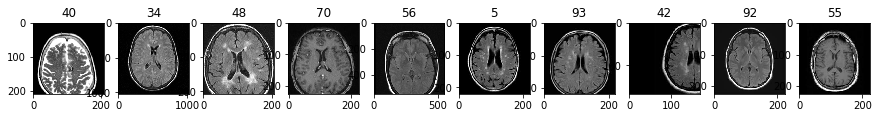

In [164]:
fig, axs = plt.subplots(1, 10, figsize=(15, 20))

indexes = list(range(0, 98))
random.shuffle( indexes )
for a, i in enumerate(indexes[:10]):
    axs[a].set_title(f"{i}")
    axs[a].imshow(cropped_tumor_n[i], cmap='gray')

In [165]:
sizes = [img.shape for img in cropped_tumor_n] + [img.shape for img in cropped_tumor_n]
# Checa menores valores para colunas e linhas
min_col = min(sizes, key= lambda t: t[0])
min_row = min(sizes, key= lambda t: t[1])
print(min(sizes, key= lambda t: t[0]))
print(min(sizes, key= lambda t: t[1]))

rsz_shape = (min_col[0], min_row[1])
print(f"A dimensão será ({rsz_shape[0]}, {rsz_shape[1]})")

(150, 150)
(150, 150)
A dimensão será (150, 150)


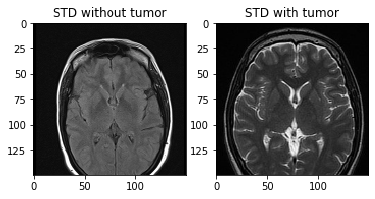

In [166]:
rsz_tumor_n = np.array([ cv2.resize(img, rsz_shape) for img in cropped_tumor_n])
rsz_tumor_y = np.array([ cv2.resize(img, rsz_shape) for img in cropped_tumor_y])

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(rsz_tumor_n[56], cmap='gray')
ax1.set_title('STD without tumor')
ax2.imshow(rsz_tumor_n[65], cmap='gray')
ax2.set_title('STD with tumor')
plt.show()

In [176]:
new_path = '../data/processed'
new_abs_path = os.path.abspath(new_path)
new_folder = f"{new_abs_path}/no"
if not os.path.exists(new_folder):
    os.mkdir(new_folder) 

for i, image in enumerate(rsz_tumor_n):
    cv2.imwrite(f"{new_folder}/N{i}.jpg", image)
        
new_folder = f"{new_abs_path}/yes"
if not os.path.exists(new_folder):
    os.mkdir(new_folder)
for i, image in enumerate(rsz_tumor_y):
    cv2.imwrite(f"{new_folder}/Y{i}.jpg", image)

## Variabilidade
Com as imagens reguladas, checamos se há diferença de variabilidade entre as classes

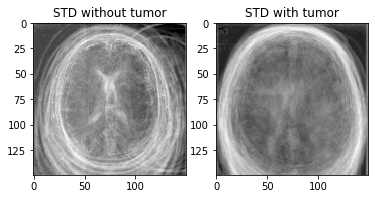

In [167]:
var_tumor_n = rsz_tumor_n.std(axis=0).astype(int)
var_tumor_y = rsz_tumor_y.std(axis=0).astype(int)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(var_tumor_n, cmap='gray')
ax1.set_title('STD without tumor')
ax2.imshow(var_tumor_y, cmap='gray')
ax2.set_title('STD with tumor')
plt.show()

Podemos ver que as imagens sem tumor possuem maior variabilidade

## Autoimagens

Com as autoimagens, pegamos os autovetores do PCA da matriz para visualizar os componentes que descrevem as classes

Número de componentes NORMAL:  17


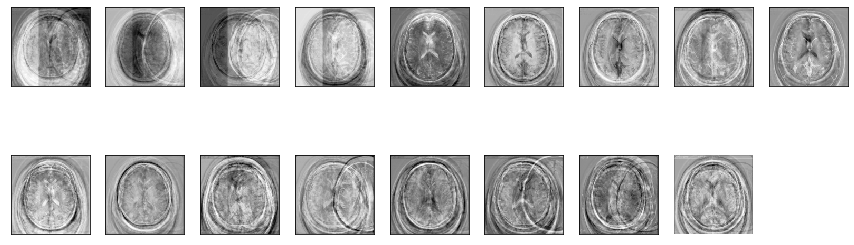

Número de componentes TUMOR:  25


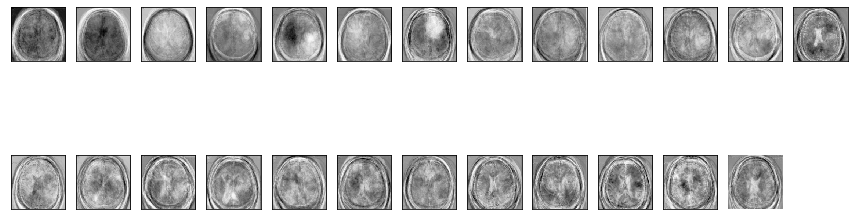

In [168]:
def eigenimages(full_mat, title, n_comp = 0.7, size = (64, 64)):
    # fit PCA to describe n_comp * variability in the class
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(full_mat)
    print(f"Número de componentes {title}: ", pca.n_components_)
    return pca
  
def plot_pca(pca, size = rsz_shape):
    # plot eigenimages in a grid
    n = pca.n_components_
    fig = plt.figure(figsize=(15, 5))
    r = int(n**.3)
    c = ceil(n/ r)
    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape(size), 
                  cmap='Greys_r')
    plt.axis('off')
    plt.show()

n_no = len(brain_tumor_n)
n_yes = len(brain_tumor_y)
plot_pca(eigenimages(rsz_tumor_n.reshape((n_no, -1)), 'NORMAL'))
plot_pca(eigenimages(rsz_tumor_y.reshape((n_yes, -1)), 'TUMOR'))